## 🗂️ Columns Explained

| **Column Name** | **Description** | **Type** |
|------------------|-----------------|-----------|
| **CompanyID** | Unique identifier for each synthetic company | Numeric |
| **CompanyName** | Synthetic name (e.g., "Company_123") | Categorical |
| **Industry** | Industry sector (e.g., Technology, Finance, Energy) | Categorical |
| **Region** | Geographic region (e.g., North America, Europe) | Categorical |
| **Year** | Reporting year (2015–2025) | Numeric |
| **Revenue** | Annual revenue in millions USD | Numeric |
| **ProfitMargin** | Net profit margin as percentage of revenue | Numeric |
| **MarketCap** | Market capitalization in millions USD | Numeric |
| **GrowthRate** | Year-over-year revenue growth rate (%) | Numeric (NaN for 2015) |
| **ESG_Overall** | Aggregate ESG sustainability score (0–100) | Numeric |
| **ESG_Environmental** | Environmental sustainability score (0–100) | Numeric |
| **ESG_Social** | Social responsibility score (0–100) | Numeric |
| **ESG_Governance** | Corporate governance quality score (0–100) | Numeric |
| **CarbonEmissions** | Annual carbon emissions in tons CO₂ | Numeric |
| **WaterUsage** | Annual water usage in cubic meters | Numeric |
| **EnergyConsumption** | Annual energy consumption in megawatt-hours (MWh) | Numeric |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.colors as pc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)

In [2]:
df = pd.read_csv("company_esg_financial_dataset.csv")
df.sample(10)

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
7598,691,Company_691,Healthcare,Latin America,2023,6313.2,17.9,23387.8,4.0,65.7,69.4,76.7,51.0,450945.9,450945.9,901891.7
6877,626,Company_626,Healthcare,Europe,2017,4385.8,14.2,13347.5,17.1,69.7,48.2,76.7,84.4,378426.0,378426.0,756851.9
373,34,Company_34,Energy,Middle East,2025,21020.8,14.8,43800.0,16.3,34.8,58.4,16.3,29.6,16627583.0,4988274.9,166275829.7
663,61,Company_61,Consumer Goods,Oceania,2018,2031.9,11.7,2430.0,-2.1,78.7,86.3,54.5,95.3,242265.5,302831.9,1211327.7
3202,292,Company_292,Utilities,Asia,2016,1074.6,9.2,933.7,-7.4,21.7,26.1,18.7,20.3,874642.4,546651.5,8746424.0
7024,639,Company_639,Healthcare,Latin America,2021,1512.9,-3.1,5762.2,15.3,27.0,23.1,32.9,24.9,157056.6,157056.6,314113.3
3973,362,Company_362,Technology,Africa,2017,1991.9,15.1,8910.7,10.1,38.1,95.7,5.3,13.5,52818.7,31691.2,105637.4
5152,469,Company_469,Retail,Middle East,2019,1549.6,2.2,352.3,10.7,47.1,29.1,60.8,51.3,154427.5,77213.7,308854.9
5986,545,Company_545,Manufacturing,North America,2017,4373.4,12.5,10255.9,7.6,51.9,32.2,69.9,53.7,1278810.1,1705080.1,21313501.6
6580,599,Company_599,Transportation,Latin America,2017,642.1,0.3,36.2,-22.2,51.4,37.7,71.0,45.5,360760.2,60126.7,1202534.1


In [3]:
kpi = df.groupby("Year").agg({
    "Revenue": "sum",
    "MarketCap": "sum",
    "ProfitMargin": "mean",
    "ESG_Overall": "mean"
}).reset_index()

print(kpi)

    Year    Revenue   MarketCap  ProfitMargin  ESG_Overall
0   2015  3305840.5   9091156.6       10.8791      51.4419
1   2016  3478708.7   9657369.7       10.9506      52.0439
2   2017  3705968.1  10435220.8       10.9897      52.6777
3   2018  3942490.6  10745081.7       10.9388      53.3514
4   2019  4214272.9  11618069.2       10.8880      53.9070
5   2020  4494454.9  12711744.3       10.7829      54.5884
6   2021  4818389.5  13542917.7       10.9038      55.2397
7   2022  5173362.6  14974626.9       10.9219      55.9208
8   2023  5599792.1  16193491.9       10.9316      56.5865
9   2024  6063939.9  18874133.7       10.9532      57.1767
10  2025  6582136.7  19343032.1       10.7654      57.8340


In [ ]:
#  take the last 2 years
latest_year = kpi["Year"].max()
prev_year = kpi["Year"].nlargest(2).iloc[-1] if len(kpi) > 1 else None

latest_row = kpi.loc[kpi["Year"] == latest_year].iloc[0]
prev_row = kpi.loc[kpi["Year"] == prev_year].iloc[0]

revenue_change = ((latest_row["Revenue"] - prev_row["Revenue"]) / abs(prev_row["Revenue"])) * 100
marketcap_change = ((latest_row["MarketCap"] - prev_row["MarketCap"]) / abs(prev_row["MarketCap"])) * 100

print(f"Revenue {latest_year}: {latest_row['Revenue']}, delta: {revenue_change:.2f}%")
print(f"Market Cap {latest_year}: {latest_row['MarketCap']}, delta: {marketcap_change:.2f}%")
print(f"Profit Margin {latest_year}: {latest_row['ProfitMargin']:.2f}%")
print(f"ESG Score {latest_year}: {latest_row['ESG_Overall']:.2f}")

Revenue 2025: 6582136.7, delta: 8.55%
Market Cap 2025: 19343032.1, delta: 2.48%
Profit Margin 2025: 10.77%
ESG Score 2025: 57.83


In [6]:
df.columns

Index(['CompanyID', 'CompanyName', 'Industry', 'Region', 'Year', 'Revenue',
       'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall',
       'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions',
       'WaterUsage', 'EnergyConsumption'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CompanyID          11000 non-null  int64  
 1   CompanyName        11000 non-null  object 
 2   Industry           11000 non-null  object 
 3   Region             11000 non-null  object 
 4   Year               11000 non-null  int64  
 5   Revenue            11000 non-null  float64
 6   ProfitMargin       11000 non-null  float64
 7   MarketCap          11000 non-null  float64
 8   GrowthRate         10000 non-null  float64
 9   ESG_Overall        11000 non-null  float64
 10  ESG_Environmental  11000 non-null  float64
 11  ESG_Social         11000 non-null  float64
 12  ESG_Governance     11000 non-null  float64
 13  CarbonEmissions    11000 non-null  float64
 14  WaterUsage         11000 non-null  float64
 15  EnergyConsumption  11000 non-null  float64
dtypes: float64(11), int64(

In [8]:
df.describe()

,CompanyID,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,10000.000000,11000.000000,11000.000000,11000.000000,11000.000000,1.100000e+04,1.100000e+04,1.100000e+04
mean,500.500000,2020.000000,4670.850591,10.900455,13380.622236,4.830370,54.615273,56.416991,55.660582,51.767655,1.271462e+06,5.600442e+05,1.165839e+07
std,288.688113,3.162421,9969.954369,8.758711,39922.870373,9.424787,15.893937,26.767233,23.356152,25.323370,5.067760e+06,1.565686e+06,5.095836e+07
min,1.000000,2015.000000,35.900000,-20.000000,1.800000,-36.000000,6.300000,0.000000,0.000000,0.000000,2.042200e+03,1.021100e+03,5.105500e+03
25%,250.750000,2017.000000,938.775000,5.300000,1098.525000,-1.325000,44.100000,34.700000,37.600000,30.775000,1.228530e+05,6.488467e+04,3.069161e+05
50%,500.500000,2020.000000,1902.300000,10.500000,3096.450000,4.900000,54.600000,55.600000,55.150000,52.100000,2.920734e+05,2.038805e+05,1.221745e+06
75%,750.250000,2023.000000,4342.625000,16.300000,9995.500000,11.000000,65.600000,79.000000,73.800000,73.000000,7.407311e+05,5.251880e+05,5.616437e+06
max,1000.000000,2025.000000,180810.400000,50.000000,865271.700000,38.000000,98.800000,100.000000,100.000000,100.000000,1.741047e+08,5.223142e+07,1.741047e+09


In [9]:
# Checking every row when GrowthRate is NaN
df[df["GrowthRate"].isnull()] # NaN is happen because Growth can't be calculated already in 2015

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,NaN,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7
11,2,Company_2,Retail,Asia,2015,2934.8,-2.9,1803.1,NaN,59.9,61.1,48.6,69.8,226554.2,113277.1,453108.3
22,3,Company_3,Transportation,Latin America,2015,259.7,5.9,140.2,NaN,25.5,3.3,41.6,31.5,183314.5,30552.4,611048.2
33,4,Company_4,Technology,Africa,2015,5036.7,21.2,23192.4,NaN,54.2,97.6,46.2,18.9,130146.6,78087.9,260293.2
44,5,Company_5,Finance,Middle East,2015,2720.9,16.1,3884.5,NaN,43.5,71.9,19.1,39.4,37894.7,18947.3,94736.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10945,996,Company_996,Healthcare,Europe,2015,3099.7,18.2,11376.4,NaN,57.4,75.5,39.7,56.9,208168.1,208168.1,416336.3
10956,997,Company_997,Utilities,Africa,2015,537.0,15.7,716.1,NaN,61.2,44.9,82.4,56.4,380375.4,237734.6,3803753.9
10967,998,Company_998,Healthcare,Oceania,2015,1055.4,14.9,3871.5,NaN,62.2,96.3,25.1,65.3,55490.0,55490.0,110980.0
10978,999,Company_999,Finance,Asia,2015,5928.4,18.2,9585.9,NaN,52.8,95.3,25.1,38.1,63210.0,31605.0,158025.0


In [10]:
# replace NaN with 0 because Growth in 2025 has no compariason in the previous year
df["GrowthRate"] = df["GrowthRate"].fillna(0)
df.head()

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,0.0,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8


In [11]:
# checking for the results, 0 if successfull
df["GrowthRate"].isnull().sum()

0

In [12]:
# Visualization of the revenue per industry
rev_ind = df.groupby("Industry")["Revenue"].sum().reset_index()
rev_ind.columns = ["Industry", "Revenue"]
fig = px.pie(rev_ind, names="Industry", values="Revenue", color_discrete_map=pc.qualitative.Pastel, hole=.3, title="Revenue per Industry")
fig.show()

In [13]:
# visualization of the revenua tren from 2015 to 2025
yearly_rev = df.groupby("Year")["Revenue"].sum().reset_index()
fig = px.line(yearly_rev, x="Year", y="Revenue", title="Revenue Trend")
fig.show()

In [14]:
# visualization of the MarketCap trend
yearly_rev = df.groupby("Year")["MarketCap"].sum().reset_index()
fig = px.line(yearly_rev, x="Year", y="MarketCap", title="MarketCap Trend")
fig.show()

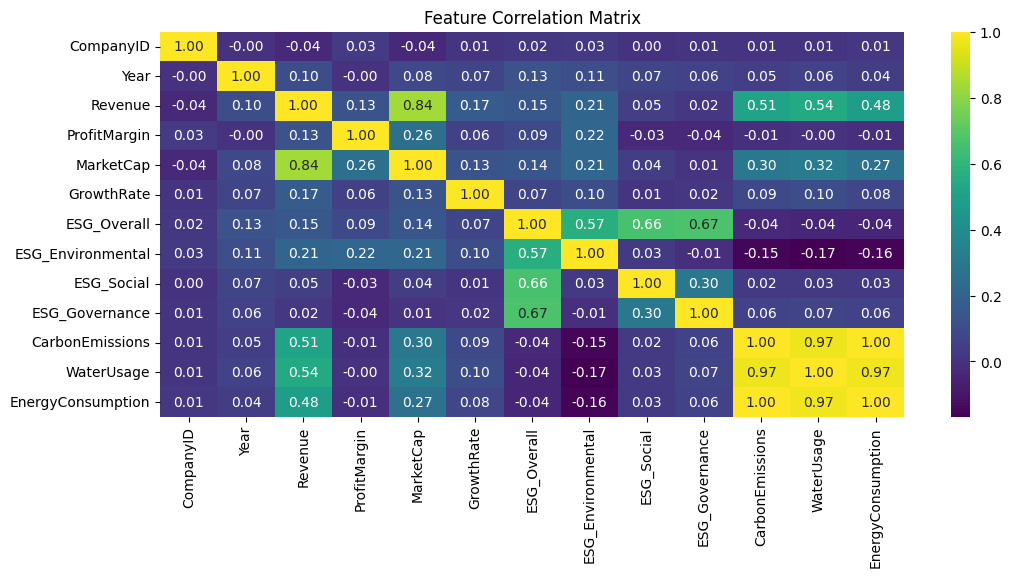

In [15]:
# visualization for feature correalation matrix
plt.figure(figsize=(12,5))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', annot=True, fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

In [16]:
# Correlation of marketcap and revenue
fig = px.scatter(df, x="MarketCap", y="Revenue")
fig.show()

# Revenue Prediction
We use the financial and ESG information to built a model

In [17]:
# make a copy dataframe
data = df.copy()

In [18]:
data.columns

Index(['CompanyID', 'CompanyName', 'Industry', 'Region', 'Year', 'Revenue',
       'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall',
       'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions',
       'WaterUsage', 'EnergyConsumption'],
      dtype='object')

In [19]:
X = data[['ProfitMargin', 'MarketCap', 'ESG_Overall', 'ESG_Environmental',
       'ESG_Social', 'ESG_Governance', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption']]
y = data['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
        }
    },
    
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__criterion': ['squared_error', 'friedman_mse', 'absolute_error']  
        }
    },
    
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4] 
        }
    }
}

results = []

for name, mp in model_params.items():
    print(f"\n🔍Tuning Model {name}")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])
    grid = GridSearchCV(pipe, mp['params'],
                        cv=5, scoring='r2',
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'CV Score (mean)': grid.best_score_,
        'R2 Test': r2_score(y_test, y_pred),
        'MSE Test': mean_squared_error(y_test, y_pred),
        'MAE Test': mean_absolute_error(y_test, y_pred)
    })

# Ubah hasil jadi dataframe dan urutkan berdasarkan R² tertinggi
results_df = pd.DataFrame(results).sort_values(by='R2 Test', ascending=False).reset_index(drop=True)

print("\n📊 Hasil Akhir:")
print(results_df)


🔍Tuning Model Linear Regression

🔍Tuning Model Decision Tree

🔍Tuning Model Random Forest

📊 Hasil Akhir:
               Model  \
0      Random Forest   
1      Decision Tree   
2  Linear Regression   

                                                                                                                  Best Params  \
0         {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}   
1  {'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}   
2                                                                                                                          {}   

   CV Score (mean)   R2 Test      MSE Test     MAE Test  
0         0.897775  0.937712  8.644214e+06   730.926082  
1         0.846411  0.889580  1.532394e+07  1119.855939  
2         0.829587  0.885575  1.587970e+07  2069.272950  


In [21]:
results_df

,Model,Best Params,CV Score (mean),R2 Test,MSE Test,MAE Test
0,Random Forest,"{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}",0.897775,0.937712,8.644214e+06,730.926082
1,Decision Tree,"{'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}",0.846411,0.889580,1.532394e+07,1119.855939
2,Linear Regression,{},0.829587,0.885575,1.587970e+07,2069.272950


In [22]:
RF_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(max_depth=None, 
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    n_estimators=300))
])

RF_pipe.fit(X_train, y_train)

y_pred = RF_pipe.predict(X_test)

print('R2: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))

R2:  0.9357813440938634
MAE:  733.2808269696972
MSE:  8912158.828193065


# Segmentation

In [23]:
features = ['Revenue', 'ProfitMargin', 'MarketCap', 'ESG_Overall',
       'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions',
       'WaterUsage', 'EnergyConsumption']
data_unscaled = data[features]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_unscaled)
data_scaled = pd.DataFrame(data_scaled, columns=data_unscaled.columns)

kmeans = KMeans(n_clusters=3, random_state=42)
data["Cluster"] = kmeans.fit_predict(data_scaled)
data.head()

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption,Cluster
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,0.0,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7,2
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4,2
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9,2
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2,2
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8,2


In [24]:
# count the average value of esg_overall and revenue
cluster_summary = (data.groupby("Cluster")[["ESG_Overall", "Revenue"]]
                   .mean().sort_values(["ESG_Overall", "Revenue"], ascending=[True, True]))
# order dari rendah ke tinggi
cluster_order = cluster_summary.index
mapping = {old: new for new, old in enumerate(cluster_order)}
# menerapkan urutan ke dataframe
data["Cluster"] = data["Cluster"].map(mapping)
data["Segment"] = data["Cluster"].map({0:"Low", 1:"Middle", 2: "High"})
data.head()

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption,Cluster,Segment
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,0.0,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7,1,Middle
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4,1,Middle
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9,1,Middle
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2,1,Middle
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8,1,Middle


In [25]:
columns = ['Revenue', 'ProfitMargin', 'MarketCap', 'ESG_Overall',
       'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions',
       'WaterUsage', 'EnergyConsumption']
summary = data.groupby("Segment")[columns].mean().round(2)
summary

,Revenue,ProfitMargin,MarketCap,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
Segment,,,,,,,,,,
High,8131.67,15.60,29064.55,69.85,83.37,64.07,62.11,429114.03,280799.76,2349809.93
Low,2815.58,11.13,6789.62,39.20,49.43,37.48,30.69,948227.84,459827.90,8682096.03
Middle,3615.52,6.48,6626.08,57.84,40.10,67.93,65.48,2369279.20,916447.50,23143549.13


In [26]:
summary.corr()

,Revenue,ProfitMargin,MarketCap,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
Revenue,1.000000,0.780714,0.989313,0.873793,0.940629,0.520056,0.544391,-0.601186,-0.613288,-0.632836
ProfitMargin,0.780714,1.000000,0.863485,0.378300,0.946472,-0.127723,-0.099163,-0.968709,-0.972377,-0.977906
MarketCap,0.989313,0.863485,1.000000,0.793548,0.980069,0.389957,0.416264,-0.711279,-0.721902,-0.738971
ESG_Overall,0.873793,0.378300,0.793548,1.000000,0.656848,0.869784,0.883607,-0.136707,-0.151780,-0.176434
ESG_Environmental,0.940629,0.946472,0.980069,0.656848,1.000000,0.199256,0.227340,-0.836740,-0.844983,-0.858085
ESG_Social,0.520056,-0.127723,0.389957,0.869784,0.199256,1.000000,0.999587,0.369895,0.355700,0.332233
ESG_Governance,0.544391,-0.099163,0.416264,0.883607,0.227340,0.999587,1.000000,0.343037,0.328690,0.304985
CarbonEmissions,-0.601186,-0.968709,-0.711279,-0.136707,-0.836740,0.369895,0.343037,1.000000,0.999884,0.999191
WaterUsage,-0.613288,-0.972377,-0.721902,-0.151780,-0.844983,0.355700,0.328690,0.999884,1.000000,0.999688
EnergyConsumption,-0.632836,-0.977906,-0.738971,-0.176434,-0.858085,0.332233,0.304985,0.999191,0.999688,1.000000


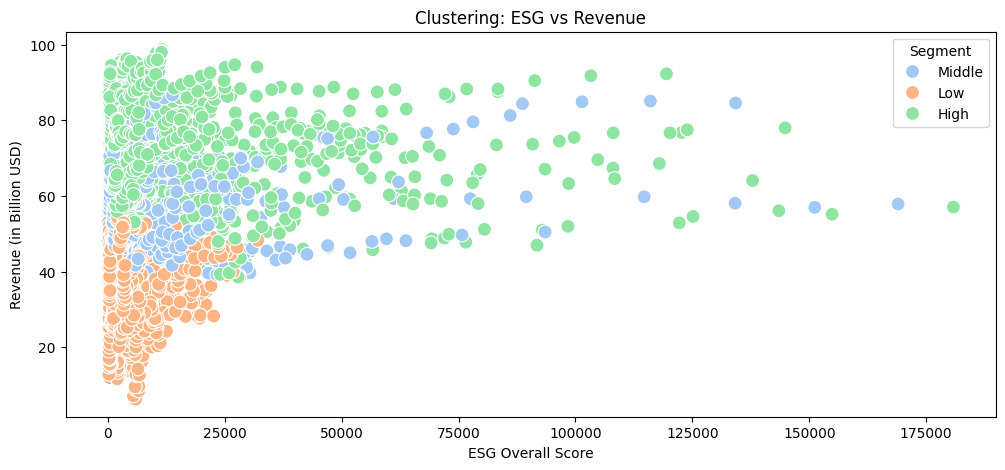

In [27]:
plt.figure(figsize=(12,5))
sns.scatterplot(
    data, x="Revenue", y="ESG_Overall",
    hue="Segment", palette='pastel',
    s=100
)
plt.title("Clustering: ESG vs Revenue")
plt.legend(title="Segment")
plt.xlabel("ESG Overall Score")
plt.ylabel("Revenue (in Billion USD)")
plt.show()